# Toy 4 (Exponential): Follow the Authors' Built-in Functions

In [1]:
import torch
from kan import create_dataset
from kan.custom import MultKAN
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

f = lambda x: torch.exp(-2 * x[:, [0]]) + x[:, [1]]
dataset = create_dataset(f, n_var=2, train_num=1000, test_num=100, device=device, normalize_label=True)

In [ ]:
model = MultKAN(width=[2,2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20, lamb=0.002, lamb_entropy=2.)
model.plot()

In [ ]:
model = model.prune(edge_th=1e-2)
model.plot()

In [ ]:
grids = [3, 5, 10, 20, 50]

train_rmse = []
test_rmse = []

for i in range(len(grids)):
    model = model.refine(grids[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse.append(results['train_loss'][-1].item())
    test_rmse.append(results['test_loss'][-1].item())


In [ ]:
n_params = np.array(grids) * (2*2+2*1)
plt.plot(n_params, train_rmse, marker="o")
plt.plot(n_params, test_rmse, marker="o")
plt.plot(n_params, 300*n_params**(-2.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

그냥 학습하는 것보다 조금씩 grid를 refine해가는 것이 성능을 좋게 한다.

아래는 매번 새로운 KAN을 정의하고 바로 처음부터 finer grid로 학습하는 예시.

오히려 grid가 많을수록 학습이 덜 되어서 정확도가 떨어진다.

In [ ]:
train_rmse_restart = []
test_rmse_restart = []

for i in range(len(grids)):
    model = MultKAN(width=[2,2,1], grid=grids[i], k=3, seed=0, device=device)
    results = model.fit(dataset, opt="LBFGS", steps=50, stop_grid_update_step=30)
    train_rmse_restart.append(results['train_loss'][-1].item())
    test_rmse_restart.append(results['test_loss'][-1].item())

n_params = np.array(grids) * (2*2+2*1)
plt.plot(n_params, train_rmse_restart, marker="o")
plt.plot(n_params, train_rmse_restart, marker="o")
plt.plot(n_params, 300*n_params**(-2.), color="black", ls="--")
plt.legend(['train', 'test', r'$N^{-4}$'], loc="lower left")
plt.xscale('log')
plt.yscale('log')
print(train_rmse)
print(test_rmse)

배신: 사실 layer가 1단계만 있으면 바로 학습한다....

| train_loss: 1.42e-02 | test_loss: 1.49e-02 | reg: 2.21e+00 | : 100%|█| 20/20 [00:02<00:00,  9.48it
| train_loss: 3.15e-05 | test_loss: 3.66e-05 | reg: 4.65e+00 | : 100%|█| 50/50 [00:01<00:00, 30.45it


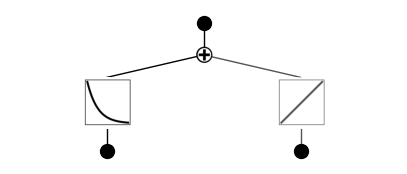

In [2]:
# grids_to_sym = [3, 5, 10, 20]
grids_to_sym = [10]

train_rmse_sym = []
test_rmse_sym = []

model = MultKAN(width=[2,1], grid=3, k=3, seed=0, device=device)
model.fit(dataset, opt='LBFGS', steps=20,
          lamb=0.01, lamb_entropy=0.1, lamb_coef=0.1, lamb_coefdiff=0.5)
model = model.prune(edge_th=0.03, node_th=0.01)

for i in range(len(grids_to_sym)):
    model = model.refine(grids_to_sym[i])
    results = model.fit(dataset, opt='LBFGS', steps=50, stop_grid_update_step=20)
    train_rmse_sym.append(results['train_loss'][-1].item())
    test_rmse_sym.append(results['test_loss'][-1].item())

model.plot()

In [3]:
model.auto_symbolic()

r2 is 1.0000003576278687
fixing (0,0,0) with exp, r2=1.0, c=2
r2 is 1.0000004768371582
fixing (0,1,0) with x, r2=1.0, c=1


In [4]:
from kan.utils import ex_round
ex_round(model.symbolic_formula()[0][0], 4)

0.5095*x_2 - 0.929 + 0.5095*exp(-2.0*x_1)

Text(0, 0.5, 'Attribution score')

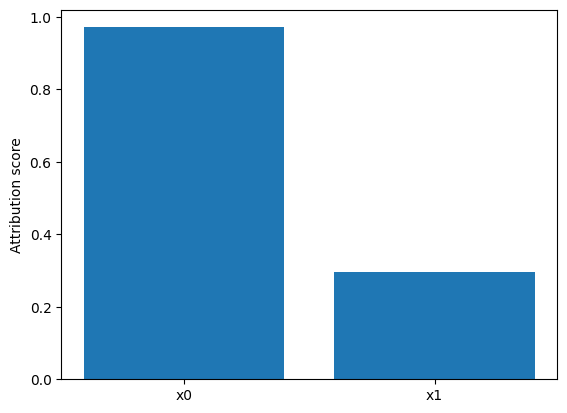

In [5]:
fig, ax = plt.subplots()
model.forward(dataset['train_input'])
scores_tot = model.feature_score
ax.bar([f"x{i}" for i in range(scores_tot.shape[0])], scores_tot.tolist())
# ax.set_xticks([f"x{i}" for i in range(score_L0.shape[0])])
ax.set_ylabel("Attribution score")

[tensor(251), tensor(241), tensor(256), tensor(252)]


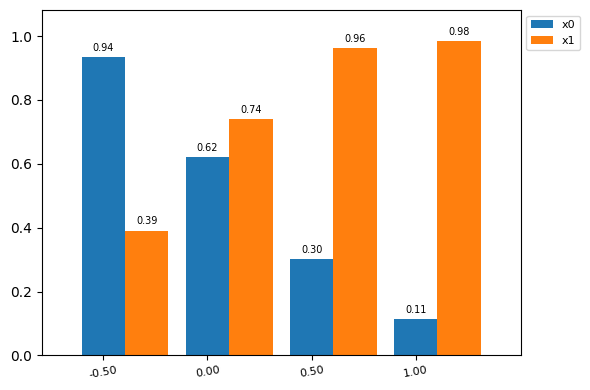

In [6]:
mask_idx = 0
mask_interval = [-1, -0.5, 0., 0.5, 1]
# mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        model.forward(x_tensor_masked)
        scores_interval.append(model.feature_score.detach().cpu().numpy())
    else:
        scores_interval.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

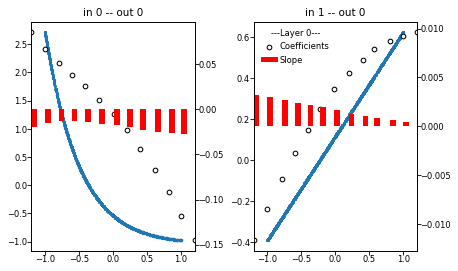

[<Figure size 450x262.5 with 4 Axes>]

In [7]:
from kan.custom_utils import plot_activation_and_spline_coefficients

plot_activation_and_spline_coefficients(model, x=dataset)

학습이 안정적으로 되고 나면 spline coefficients의 값 자체도 신뢰할 만함.

Spline coefficients의 값 ~ 함수의 값 이라고 보면 안 되나?

한 가지 설명이 안 되는 것은 Spline coefficients의 기울기가 변하는 것은 덜 중요한 변수에서 관찰됨.

In [8]:
model.subnode_actscale

[tensor([1.0000])]

한 번 spline coefficients의 기울기 방향이 변하는 x1의 영역에 대해서 attribution score를 추적하자.

[tensor(757), tensor(243)]


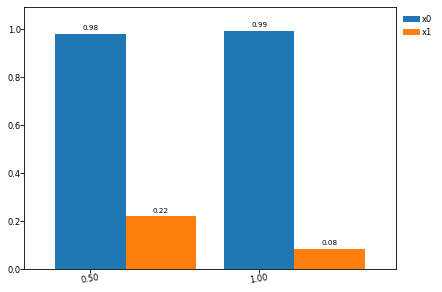

In [13]:
mask_idx = 1
# mask_interval = [-1, -0.5, 0., 0.5, 1]
mask_interval = [-1, 0.5, 1]

x_mask = dataset['train_input'][:, mask_idx]
y_vals = dataset['train_label'].ravel()

masks = [ ((x_mask > lb) & (x_mask <= ub)) for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
labels = [f'{ub:.2f}' for lb, ub in zip(mask_interval[:-1], mask_interval[1:])]
print([sum(x) for x in masks])

scores_interval = []
scores_interval_norm = []
for mask in masks:
    if np.any(mask.numpy()):
        x_tensor_masked = dataset['train_input'][mask, :]
        x_std = torch.std(x_tensor_masked, dim=0).detach().cpu().numpy()
        model.forward(x_tensor_masked)

        score_masked = model.feature_score.detach().cpu().numpy()
        score_norm = score_masked / x_std
        scores_interval.append(score_masked)
        scores_interval_norm.append(score_norm)
    else:
        scores_interval.append(np.zeros(scores_tot.shape))
        scores_interval_norm.append(np.zeros(scores_tot.shape))

width = 0.25
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()

Attribution score가 input data의 분포에 영향을 받기 때문에 input의 std로 나눠서 비교하기 -- x1의 영역에 대해서는 attribution score의 역전이 일어나지 않음. 

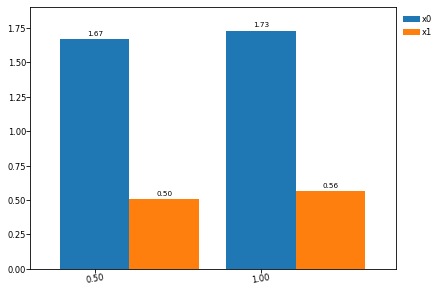

In [14]:
fig, ax = plt.subplots(figsize=(6,4))
xticks = np.arange(len(masks)) * (width * scores_tot.shape[0] * 1.2)
xticklabels = labels
max_score = max([max(s) for s in scores_interval_norm])
for idx in range(scores_tot.shape[0]):
    bars = ax.bar(xticks + idx * width, [s[idx] for s in scores_interval_norm], width, label=f"x{idx}")
    ax.bar_label(bars, fmt='%.2f', fontsize=7, padding=3)
ax.margins(x=0.1)
ax.set_ylim(0, max_score * 1.1)

ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=10, ha='center', fontsize=8)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)

plt.tight_layout()
plt.show()